# QA: Cols 15-28 (14-27)

In [44]:
import io

import pandas as pd
from pandas import DataFrame as DF, Series
import numpy as np

import requests
import re
import missingno as msn

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

## Get Data

In [2]:
import io

url = """https://raw.githubusercontent.com/hackoregon/elections-2018/
master/transaction_detail_first_batch.csv"""
r = requests.get(url.replace('\n', ''))
df = pd.read_csv(io.StringIO(r.content.decode('utf-8')), dtype={'Agent': str})
odf = pd.read_csv(io.StringIO(r.content.decode('utf-8')), dtype='O')

## Basic Inspection

### Missing Values

Visual inspection of missing values:

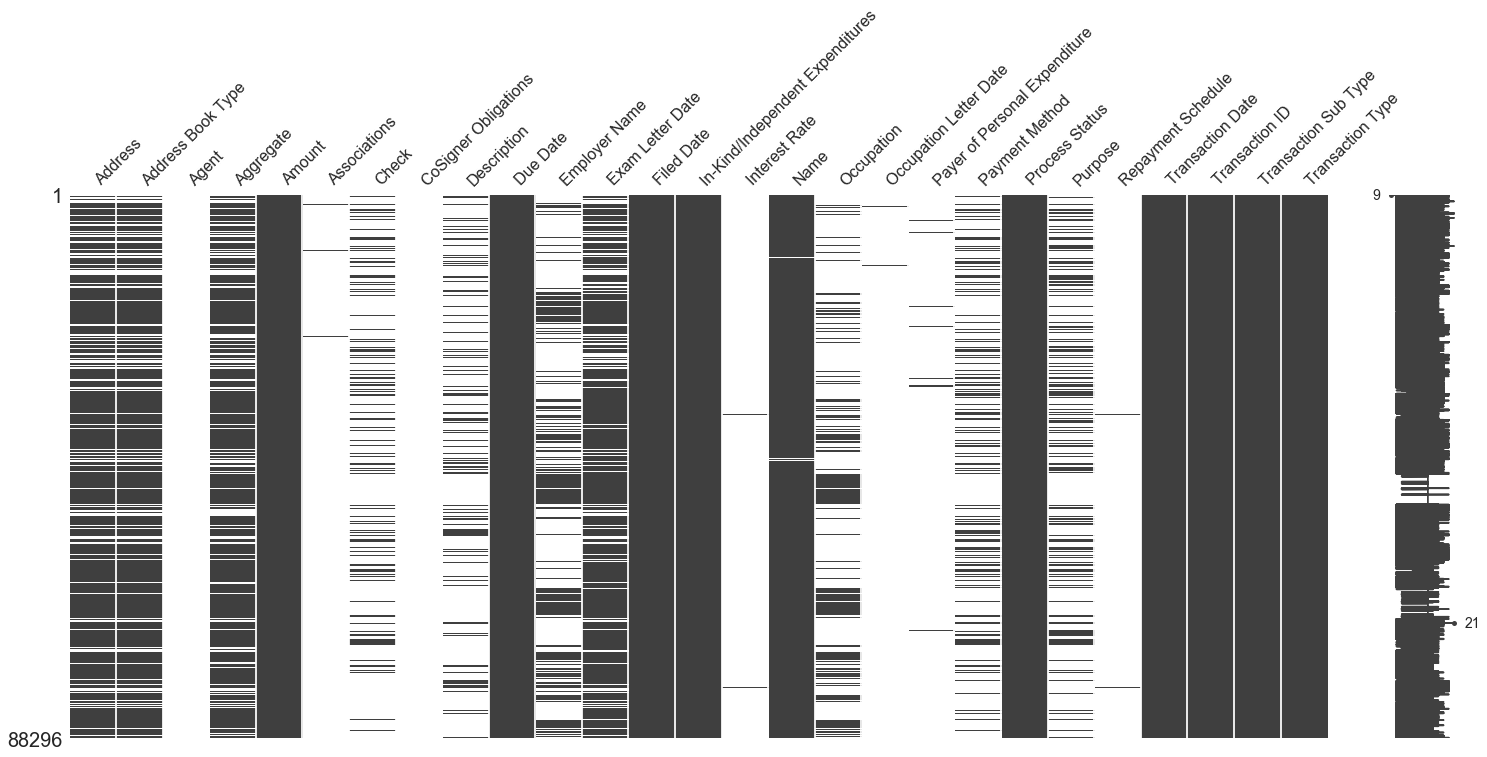

In [3]:
msn.matrix(df.iloc[14:])

Missing values per column:

In [4]:
len(df) - df.iloc[:, 14:].count()

Interest Rate                    88070
Name                               780
Occupation                       63064
Occupation Letter Date           87855
Payer of Personal Expenditure    86758
Payment Method                   66544
Process Status                       0
Purpose                          63435
Repayment Schedule               88232
Transaction Date                     0
Transaction ID                       0
Transaction Sub Type                 0
Transaction Type                     0
dtype: int64

### Unique Value Counts

In [5]:
df.iloc[:, 14:].apply(lambda x: x.nunique())

Interest Rate                      120
Name                             19262
Occupation                        2674
Occupation Letter Date             248
Payer of Personal Expenditure      198
Payment Method                       6
Process Status                       4
Purpose                            125
Repayment Schedule                  48
Transaction Date                  4101
Transaction ID                   88310
Transaction Sub Type                29
Transaction Type                     6
dtype: int64

## Visual Inspection of Columns
**(including only those with fewer than 50 unique entries)**

In [37]:
long_cols = []
for c in df.iloc[:, 14:]:
    n = df.loc[:, c].nunique()
    if n < 50:
        print(10*'-','\n')
        print('{} (unique count: {})\n'.format(c, n))
        print(df.loc[:, c].value_counts())
        print()
    else:
        long_cols.append(c)
print(20*'=', '\n')
print('Excluded Columns\n')
print(long_cols)

---------- 

Payment Method (unique count: 6)

Check                        17357
Electronic Funds Transfer     2354
Debit Card                    1640
Electronic Check               343
Credit Card                     71
Cash                             1
Name: Payment Method, dtype: int64

---------- 

Process Status (unique count: 4)

Complete                  87682
Filed                       254
Insufficient/Statutory      212
Insufficient/General        162
Name: Process Status, dtype: int64

---------- 

Repayment Schedule (unique count: 48)

When funds available                      12
repay when funds are available             4
On Demand                                  3
when funds are available                   3
As funds are available                     3
30 Days                                    3
when available                             3
6 months                                   2
as funds available                         2
ASAP                                   

All of these look good, although *Repayment Schedule* is just a mess of unique values that would ideally be grouped/consolidated.

## Looking At Longer Columns

### Transaction Date

Quick descriptive stats

In [7]:
df['Transaction Date'].describe()

count          88310
unique          4101
top       11/09/2017
freq            1656
Name: Transaction Date, dtype: object

Checking if any dates don't match the expected format, which includes any invalid values for month, day, year.

In [8]:
# return the index and value of any dates not matching expected format
date_pattern = '(0[0-9]|1[0-2])/([0-2][0-9]|3[01])/(19\d{2}|200[0-9]|201[0-8])'
df.loc[:, 'Transaction Date'][df.loc[:, 'Transaction Date'].apply(lambda x: not re.match(date_pattern, x))]

68927    05/03/0007
81289    11/03/0209
81290    02/23/0009
81291    03/14/0008
81292    02/19/0007
81293    02/19/0007
Name: Transaction Date, dtype: object

### Interest Rate

Quick descriptive stats

In [9]:
df['Interest Rate'].describe()

count     240
unique    120
top         0
freq       51
Name: Interest Rate, dtype: object

10 most frequent values

In [10]:
df['Interest Rate'].value_counts().head(10)

0           51
150.00      10
200.00       9
0.00%        7
0.00         7
2503.00      6
68389.61     4
25545.33     4
83913.84     3
6041.76      3
Name: Interest Rate, dtype: int64

Check all unique values

In [17]:
print(df['Interest Rate'].unique())

[nan '0.0' 'zero' 'none' '0' '7 percent' '0.00' '104500.00' '4105.00'
 '3105.00' '72343.75' '223.99' '1605.00' '10096.00' '605.00' '3399.00'
 '10%' '0.00%' '3.5%' '150.00' '2500.00' '1563.52' '134.61' '200.00'
 '125.00' '500.00' '133.96' '152.11' '141545.33' '98146.99' '458.87'
 '250.00' '709.53' '109389.08' '107889.08' '1470.52' '10000.00' '506.13'
 '1500.00' '94841.00' '494.97' '2850.00' '570.23' '45545.33' '418.49'
 '1516.12' '89376.36' '44045.33' '83913.84' '78389.61' '1200.11' '1312.50'
 '449.57' '42545.33' '307.08' '362.28' '41045.33' '68389.61' '60879.97'
 '900.11' '309.85' '39545.33' '271.87' '305.85' '56101.43' '1980.00'
 '51322.90' '37545.33' '600.11' '215.96' '155.23' '4850.00' '35545.33'
 '154.15' '46542.69' '42691.55' '33545.33' '29191.55' '300.11' '101.51'
 '31545.33' '19350.50' '15489.34' '13541.76' '29545.33' '27545.33'
 '6041.76' '350.00' '1610.00' '815.00' '1000.00' '25545.33' '5503.00'
 '59195.75' '55619.31' '83448.53' '52620.18' '5331.23' '79448.53' '5330.73'
 '5000

**Observations**

* There are some extremely large values for interest rate (???)
* Entry formats:
    - float
    - numeric with % symbol
    - numeric with 'percent'
    - string (e.g. 'zero')
* These could potentially be automatically reformatted

**Attempt to interperate the large Interest Rate values**

The script below converts all values in 'Amount', 'Interest Rate' and 'Aggregate' to numeric values.

In [12]:
temp = df.loc[:, ['Name', 'Amount', 'Interest Rate', 'Aggregate']].dropna().copy()
def tofloat(x):
    try:
        if x.startswith('$'):
            x = x.strip('$').replace(',', '')
        return float(x)
    except:
        return None
for c in temp:
    if c != 'Name':
        temp.loc[:, c] = temp.loc[:, c].apply(lambda x: tofloat(x))
temp[temp['Interest Rate'] > 1000].head(10)

,Name,Amount,Interest Rate,Aggregate
9091,Oregon Family Council Issues PAC (5446),32156.25,104500.00,104500.00
9092,US Postal Service,1000.00,4105.00,4105.00
9096,US Postal Service,1500.00,3105.00,3105.00
9097,Oregon Family Council Issues PAC (5446),62343.75,72343.75,72343.75
9099,US Postal Service,1000.00,1605.00,1605.00
9100,Oregon Family Council Issues PAC (5446),10000.00,10096.00,10096.00
9102,Diana Nashif,3399.00,3399.00,3399.00
31438,US Postal Service,1000.00,2500.00,2500.00
31439,Jack Louman,93.00,1563.52,1563.52
31459,Gateway Communications,32156.25,141545.33,141545.33


Group temp by 'Name' and aggregate the numeric values to determine the following:

1. Is Aggregate the total amount contributed by one Name over time?
2. Check if 

In [77]:
g = temp.groupby('Name').agg({'Amount': sum, 'Interest Rate': {'count','min','mean','max'}, 'Aggregate': max})
g[g.loc[:, ('Interest Rate', 'count')] > 1].head(10)

Amount  Aggregate Interest Rate                \
                               Amount  Aggregate           min          mean   
Name                                                                           
Bernards Garage Inc           3700.00    5560.36          0.00      0.000000   
Bill J. Burgess               2800.00    2300.00          0.00      0.000000   
C & A Consulting               780.03     500.00          0.00      0.000000   
Capitol Accounting Service    3863.99    2850.00        223.99   1686.798000   
Christopher Edwards           1500.00    1640.19          0.00      0.000000   
Costco                         455.30     506.13        101.51    315.023333   
Edward T. Wheeler           233000.00  233000.00          0.00      0.000000   
Gateway Communications      179008.30  141545.33      25545.33  51160.114167   
Granella Thompson              750.00     500.00        250.00    375.000000   
Jack Louman                   1563.52    1563.52        300.11   1005.746667   

                                             
                                  max count  
Name                                         
Bernards Garage Inc              0.00     2  
Bill J. Burgess                  0.00     2  
C & A Consulting                 0.00     3  
Capitol Accounting Service    2850.00     5  
Christopher Edwards              0.00     2  
Costco                         506.13     9  
Edward T. Wheeler                0.00    10  
Gateway Communications      141545.33    24  
Granella Thompson              500.00     2  
Jack Louman                   1563.52     6

In [78]:
agg_amount_diff = g.Aggregate.Aggregate.sub(g.Amount.Amount)
agg_amount_diff.describe()

count        93.000000
mean        363.684301
std       11726.642885
min      -37462.970000
25%           0.000000
50%           0.000000
75%          97.350000
max      100000.000000
dtype: float64

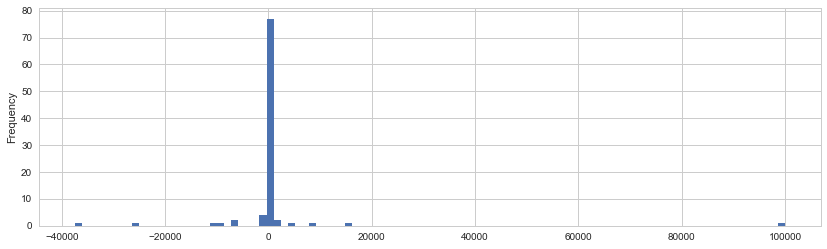

In [81]:
agg_amount_diff.plot.hist(bins=100, figsize=(14,4));

In [84]:
gtemp = g[g.loc[:, ('Interest Rate', 'max')] > 0]
agg_imax_diff = gtemp.Aggregate.Aggregate.sub(gtemp.loc[:, ('Interest Rate', 'max')])
agg_imax_diff.describe()

count    46.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
dtype: float64

The maximum value for Interest Rate (when Interest Rate is a numeric value) is always equal to the aggregate for any given Name.

What about interest rate per record? Is it always equal to the current aggregate in that record?

In [86]:
temp.Aggregate.sub(temp.loc[:, 'Interest Rate']).describe()

count       219.000000
mean       7854.356986
std       31286.684538
min           0.000000
25%           0.000000
50%           0.000000
75%         170.015000
max      233000.000000
dtype: float64

The answer to the above is no.

Are the number of unique interest rates per Name equal to the number of records per Name?

In [96]:
# summary stats for number of unique Interest Rate values per name,
# and total number of records per name
interest_nunique = temp.dropna().groupby('Name')['Interest Rate'].agg({Series.nunique, 'count'})
interest_nunique.describe()

,nunique,count
count,83.000000,83.000000
mean,1.987952,2.638554
std,3.697375,6.127862
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.500000
max,25.000000,49.000000


The following is used in the next cell, and it describes the normalized difference of number of records and number of unique Interest Rate values per Name.

$$D_p = \frac{count - nunique}{count - 1}$$

This is applied to only the names that have at least 2 records.

In [110]:
# summary stats for the difference between count per name and number of unique interest rates
# in proportion to the count
int_unique_filt = interest_nunique[interest_nunique['count'] > 1]
Dp = int_unique_filt['count'].sub(int_unique_filt['nunique']).div(int_unique_filt['count'] - 1)
Dp.describe()

count    21.000000
mean      0.525259
std       0.481310
min       0.000000
25%       0.000000
50%       0.500000
75%       1.000000
max       1.000000
dtype: float64

The number of unique Interest Rate (IR) values is inconsistent: At least 25% of the names have only one unique IR for multiple records, while another 25% (at least) have the same number of unique IR as number of records.

In [14]:
subtype_max = df.loc[:, ['Transaction Sub Type', 'Transaction ID', 'Amount']].copy()
subtype_max = subtype_max.groupby('Transaction Sub Type').max()

In [15]:
subtype_max.head(10)

,Transaction ID,Amount
Transaction Sub Type,,
Account Payable,995140,$994.61
Account Payable Rescinded,982809,"$8,857.25"
Cash Balance Adjustment,996144,($975.00)
Cash Contribution,999998,$999.51
Cash Expenditure,999688,$999.00
Expenditure Made by an Agent,494110,$862.75
In-Kind Contribution,998205,$998.28
In-Kind/Forgiven Account Payable,85299,$964.50
In-Kind/Forgiven Personal Expenditures,982816,$93.97


In [16]:
g.loc['Jack Louman']

Amount         Amount       1563.520000
Aggregate      Aggregate    1563.520000
Interest Rate  min           300.110000
               mean         1005.746667
               max          1563.520000
Name: Jack Louman, dtype: float64

### Name

In [18]:
df.Name.describe()

count                                               87530
unique                                              19262
top       Miscellaneous Cash Contributions $100 and under
freq                                                 9442
Name: Name, dtype: object

**Convert all to lower case and recheck unique count**

In [19]:
df.Name.dropna().apply(lambda x: x.lower()).describe()

count                                               87530
unique                                              19052
top       miscellaneous cash contributions $100 and under
freq                                                 9571
Name: Name, dtype: object

There are 210 fewer unique values after correcting names for case differences

**10 most common names to find any generic values**

In [20]:
df.Name.value_counts().head(10)

Miscellaneous Cash Contributions $100 and under       9442
Miscellaneous Cash Expenditures $100 and under        4989
Miscellaneous Personal Expenditures $100 and under    3237
C&E Systems                                            622
Postmaster                                             587
Bank of America                                        415
Miscellaneous In-Kind Contributions $100 and under     403
US Postal Service                                      329
Gateway Communications                                 310
Senate Democratic Leadership Fund (1471)               306
Name: Name, dtype: int64

Miscellaneous Cash/Personal Contributions/Expenditures $100 and under account for three unique values.
* Is there a Personal Contributions?
* What are the differences between these?

### Occupation

In [21]:
df.Occupation.describe()

count       25246
unique       2674
top       Dentist
freq         4576
Name: Occupation, dtype: object

There are many unique values in occupation, and surely some can be grouped together.
How is the unique count affected after correcting for case?

In [22]:
df.Occupation.dropna().apply(lambda x: x.lower()).describe()

count       25246
unique       2305
top       dentist
freq         4577
Name: Occupation, dtype: object

There are 369 fewer unique values after accounting for case.
* Digging deeper: we can also strip white space, digits, special chars.

**Most Common Values**

In [23]:
df.Occupation.value_counts().head(10)

Dentist                       4576
HOMECARE WORKER               1782
PERSONAL SUPPORT WORKER       1647
firefighter                   1501
Attorney                       806
Firefighter                    510
President                      492
Trustee                        423
Bus. Agent, Teamsters #305     349
Police officer                 344
Name: Occupation, dtype: int64

**Least Common Values**

In [24]:
df.Occupation.value_counts().tail(10)

President/General Manager                                                              1
RESTAURANT MANAGER                                                                     1
Home builder                                                                           1
Sales, ABC Office Machines, Owner, Sells & Maintains Copiers, Faxes, Printers, etc.    1
Outdoor advertiser                                                                     1
Director Government & Public Affairs                                                   1
Owner/President - Gold Hill Associates                                                 1
fundraiser                                                                             1
Chef                                                                                   1
Owner of trucking firm                                                                 1
Name: Occupation, dtype: int64

**Values that contain numbers or special characters**

In [25]:
def is_special(x):
    pattern = """[\w\s]*[!$%^&*()_+#|~=`{}\[\]:";'<>?.,/0-9]+[\w\s]*"""
    if re.match(pattern, x):
        return True
    else:
        return False
df.Occupation.dropna()[df.Occupation.dropna().apply(lambda x: is_special(x))].value_counts()

Bus. Agent, Teamsters #305                                                              349
Bus. Agent, Teamsters #162                                                              171
Trustee, Teamsters #58                                                                  133
Bus. Agent, Teamsters #58                                                               127
Union Representative, Teamsters #206                                                     98
Pres., Teamsters Jt. Council #37                                                         89
Labor Rep., Teamsters #223                                                               88
Sec.-Treas., Teamsters #962                                                              82
Sec.-Treas., Teamsters #223                                                              76
OFFICE SPECIALIST 2                                                                      70
Pres., Teamsters #162                                                           

### Occupation Letter Date

In [26]:
df['Occupation Letter Date'].describe()

count            455
unique           248
top       10/23/2012
freq              15
Name: Occupation Letter Date, dtype: object

In [27]:
# return the index and value of any dates not matching expected format
df.loc[:, 'Occupation Letter Date'].dropna()\
    [df.loc[:, 'Occupation Letter Date'].dropna().apply(lambda x: not re.match(date_pattern, x))]

Series([], Name: Occupation Letter Date, dtype: object)

Except for a null value, all dates match expected format

### Payer of Personal Expenditure

In [28]:
df['Payer of Personal Expenditure'].describe()

count              1552
unique              198
top       Bill Kennemer
freq                318
Name: Payer of Personal Expenditure, dtype: object

In [29]:
print(df['Payer of Personal Expenditure'].unique())

[nan 'Jeremy Wright' 'Marcia Latta Communications' 'Sue Tate'
 'Stefanie Craft' 'Wright Public Affairs' 'Daniel Lewkow' 'John Hartsock'
 'Bill Burgess' 'Victoria Parker' 'Patricia Schechter' 'James Barta'
 'Path To Victory Llc' 'Tony Hyde' 'Annabelle Jaramillo' 'Bill Kennemer'
 'Or Family Council - Paid To Credit Card' 'Pac/West'
 'Christopher Proudfoot' 'Celine Rixey' 'Tess Milio' 'Martha Schrader'
 'Laura Illig' 'Joy Marshall' 'Joan Obie' 'Tom Balmer' 'Tammy Baney'
 'Rhonda Bohall' 'Keri Carland' 'Jeffrey Scroggin' 'Alan Bates'
 'Laurie Bates' 'Julia Mcfadden' 'Cathy Shaw' 'Trevor Beltz' 'Chuck Keil'
 'James Bernard' 'Tom Brian' 'Hailey Sasse' 'Joseph Skipper'
 'Mackenzie Carroll' 'Nicole Watson' 'Tiernan Donohue' 'Thomas Wheatley'
 'Janet Carlson' 'Maryalice Russell' 'Steven Macy' 'Kris Olsen'
 'Joseph Justice' 'Danelle Wilson' 'Deirdre (Lindy) Moore'
 'Pelroy & Associates Llc' 'Roger Cox' 'Multnomah County' 'Robert Lawrence'
 'Duyck Machine Inc.' 'Kathy Hall' 'Brigetta Martell' 'Ch

All of the names above look reasonable

### Purpose

In [30]:
df.Purpose.describe()

count                                               24875
unique                                                125
top       General Operational Expenses (need description)
freq                                                 6213
Name: Purpose, dtype: object

In [31]:
df.Purpose.value_counts()

General Operational Expenses (need description)                                                                                                                                                    6213
Cash Contribution                                                                                                                                                                                  3608
Postage                                                                                                                                                                                            1906
Reimbursement for Personal Expenditures                                                                                                                                                            1713
Wages, Salaries, Benefits                                                                                                                                                                          1670


In [32]:
df.Purpose.dropna()[df.Purpose.dropna().apply(lambda x: x.startswith('General Operational') 
                                              or x.startswith('Literature, Brocures'))].nunique()

36

There are many versions of similar Purpose values, containing only minor differences. If we use this attribute, we should group similar values together.

### Transaction ID

In [33]:
df.loc[:, 'Transaction ID'].describe()

count       88310
unique      88310
top       1705227
freq            1
Name: Transaction ID, dtype: object

In [34]:
df.loc[:, 'Transaction ID'].head()

0    1454151
1     968825
2     934239
3     934242
4     934247
Name: Transaction ID, dtype: object

In [35]:
# are all ID values numeric?
all(df.loc[:, 'Transaction ID'].apply(lambda x: x.isnumeric()))

False

In [36]:
# get values that are not numeric
df.loc[:, 'Transaction ID'][df.loc[:, 'Transaction ID'].apply(lambda x: not x.isnumeric())].head()

38    1152259, 
40     677249, 
47     461972, 
48     461975, 
49     461971, 
Name: Transaction ID, dtype: object

There are ID values that contain commas